# Tutorial Content


This notebook will walk you through steps to read in and organize velocity data in a raster format using xarray and rioxarray tools

First, lets install the python libraries that were listed on the [Software](software.ipynb) page:

# new notebook structure (still working on)**

- brief description of notebook at top (section 1)
- raster datastream 1, ITS_LIVE geotiff ingesting and organizing (section 2)
    - look at dims, vars, crs etc
- raster datastream 2, ITS_IVE netcdf ingesting and organizing (section 3)
    - look at dims, vars, crs etc
- read in vector data (section 4)
- working with projections (section 5)
    - raster datasets have different projections (UTM and Asia_North_Lambert_Conformal_Conic)
    - should i put them into same CRS or have a different projected geodataframe of glaciers for each velocity ds, and totally separate workflows...?
        - if same crs, which prefereable btw UTM and asia norht lambert conformal conic
- once both raster types are in workable formats, start on reading in vectors etc (section 6...)


In [1]:
import geopandas as gpd
import os
import numpy as np
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

In [2]:
gen_path = '/Users/emmamarshall/Desktop/phd_research/siparcs/'

## Raster format 1 (geotiff)
This section contains a workflow for reading in and organizing ITS_LIVE glacier velocity data that is accessed in geotiff format from S3

The velocity data we are using is broken into individual velocity components. That means that for the same spatial footprint, we have a file containing ice movement in the x direction and a file containing ice movement in the y direction. We need information from both of these files so we write a function to bring both files into the jupyter notebook, then organize them so that we can see the movement of ice in both the x and y directions as well as the magnitude of the ice velocity (speed). 



In [3]:
def components_to_speed(vx_path, vy_path):
    '''this function reads in x,y components of velocity, generates speed variable. return xarray
    dataset w/ x,y, speed variables. function will break if vx,vy objects don"t have same x,y coords'''
    
    vy_da = rxr.open_rasterio(vy_path, masked=False).squeeze()
    vx_da = rxr.open_rasterio(vx_path, masked=False).squeeze()
    
    ds_gen = xr.Dataset()
    ds_gen['vx'] = vx_da
    ds_gen['vy'] = vy_da
    sp = np.sqrt((ds_gen['vx'].data**2) + ds_gen['vy'].data**2)
    ds_gen['sp'] = (['x','y'], sp.T)
    
    return ds_gen

Let's break down what exactly the above function is doing:

First, we see that it takes two inputs: vx_path and vy_path. These paths point to where on our computer the different files are stored. 

In the first two lines of the function we use rioxarray to read in the x- and the y-component files as **xarray.DataArrays**

After that, we initialize a new object, *ds_gen*, which is a **xarray.DataSet**. We then add a variable to ds_gen called 'vx' and assign the vx_da object to that variable. We do the same for vx_da. Now, we have made a dataset that is composed of the two data arrays that we read in from file. 

We are also interested in speed, so we take the equation for computing magnitude of velocity and add a third variable (DataArray) to our Dataset. 

This will add a variable defined by the equation:

            vv = (vx^2 + vy^2)^1/2

Let's execute the function and take a look at the object it returns

First, define the inputs to your function. These are the paths to the x and the y data on your computer:

In [4]:
n45_vy_path = gen_path + '/mynewbook/gardner_data/N45_0240m_vy.tiff'
n45_vx_path = gen_path + 'mynewbook/gardner_data/N45_0240m_vx.tiff'


And run the function: 

In [5]:
ds_45n = components_to_speed(n45_vx_path, n45_vy_path)

In [6]:
ds_45n

<xarray.Dataset>
Dimensions:      (x: 4440, y: 27072)
Coordinates:
    band         int64 1
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
    spatial_ref  int64 0
Data variables:
    vx           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    vy           (y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan
    sp           (x, y) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

What is the CRS of this object?

In [7]:
ds_45n.spatial_ref.attrs

{'crs_wkt': 'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / UTM zone 45N',
 'grid_mapping_name': 'trans

The above cell shows us that this data is in Universe Transverse Mercator format and that the local UTM zone is 45N. The EPSG code for this zone is EPSG:32645.

Let's take a look at the other aspects of this **xr.Dataset** object: the dimensions, coordinates, variables and attributes:

In [8]:
print(ds_45n.dims)
print('---')
print(ds_45n.coords)
print('---')
print(ds_45n.variables)
print('---')
print(ds_45n.attrs)

Frozen({'x': 4440, 'y': 27072})
---
Coordinates:
    band         int64 1
  * x            (x) float64 -3.253e+04 -3.229e+04 ... 1.033e+06 1.033e+06
  * y            (y) float64 6.297e+06 6.297e+06 ... -1.993e+05 -1.996e+05
    spatial_ref  int64 0
---
Frozen({'band': <xarray.Variable ()>
array(1), 'x': <xarray.IndexVariable 'x' (x: 4440)>
array([ -32527.5,  -32287.5,  -32047.5, ..., 1032352.5, 1032592.5, 1032832.5]), 'y': <xarray.IndexVariable 'y' (y: 27072)>
array([6297487.5, 6297247.5, 6297007.5, ..., -199072.5, -199312.5, -199552.5]), 'spatial_ref': <xarray.Variable ()>
array(0)
Attributes:
    crs_wkt:                           PROJCS["WGS 84 / UTM zone 45N",GEOGCS[...
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    inverse_flattening:                298.257223563
    reference_ellipsoid_name:          WGS 84
    longitude_of_prime_meridian:       0.0
    prime_meridian_name:               Greenwich
    geographic_crs_n

## Raster format 2 (netcdf)
This section contains a workflow for reading in and organizing ITS_LIVE glacier velocity data that is accessed in netcdf format from the NSIDC DAAC

In [9]:
itslive = xr.open_dataset('/Users/emmamarshall/Desktop/phd_research/siparcs/HMA_G0120_0000.nc')


Let's go through the same process of looking at the CRS information and dataset structure:

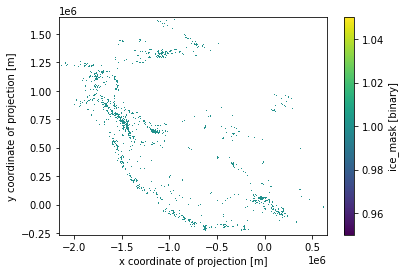

In [21]:
itslive.ice.plot()

In [18]:
itslive.rock.data

print('total pixels: ', itslive.rock.data.shape[0] * itslive.rock.data.shape[1])
print('rock pixels: ', np.count_nonzero(itslive.rock.data == 1.))
print('non rock pixels: ', np.count_nonzero(itslive.rock.data != 1.))

print(' prop  rock pixels: ', np.count_nonzero(itslive.rock.data == 1.)/ (itslive.rock.data.shape[0] * itslive.rock.data.shape[1]))


total pixels:  372789760
rock pixels:  365939342
non rock pixels:  6850418
 prop  rock pixels:  0.9816239104850949


This object has a bit different structure because we opened it with **xarray** rather than **rioxarray**. The earlier object had a coordinate called *spatial_ref* that had information stored in its attributes. Here we have a variable called *UTM_Projection* that has similar information stored in its attributes.

In [15]:
itslive.UTM_Projection

<xarray.DataArray 'UTM_Projection' ()>
array(b'', dtype='|S1')
Attributes:
    grid_mapping_name:        universal_transverse_mercator
    utm_zone_number:          27.0
    semi_major_axis:          6378137.0
    inverse_flattening:       298.257223563
    CoordinateTransformType:  Projection
    CoordinateAxisTypes:      GeoX GeoY
    GeoTransform:             -2160007.5 120.0 0 1643527.5 0 -120.0
    spatial_ref:              PROJCS["Asia_North_Lambert_Conformal_Conic",GEO...
    spatial_proj4:            +proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=...
    spatial_epsg:             102027.0

This object contains many more data variables, including velocity components (vx and vy) and magnitude of velocity (v), so we don't need to construct that ourselves. The other variables are error estimates, metadata with information about the data collection dates (date, dt), how the velocity data was constructed (count, chip_size_max), and land surface information (rock, ice, ocean).

In [16]:
itslive.data_vars

Data variables:
    vx              (y, x) float32 ...
    vy              (y, x) float32 ...
    v               (y, x) float32 ...
    vx_err          (y, x) float32 ...
    vy_err          (y, x) float32 ...
    v_err           (y, x) float32 ...
    date            (y, x) timedelta64[ns] ...
    dt              (y, x) timedelta64[ns] ...
    count           (y, x) float32 ...
    chip_size_max   (y, x) float32 ...
    ocean           (y, x) float32 ...
    rock            (y, x) float32 ...
    ice             (y, x) float32 ...
    UTM_Projection  |S1 b''

In [ ]:
itslive.dims

In [ ]:
itslive.coords

## Vector data 

In [ ]:
#read in vector data 
se_asia = gpd.read_file('/Users/emmamarshall/Downloads/15rgi60SouthAsiaEast/15_rgi60_SouthAsiaEast.shp')

How many glaciers are in this dataframe?

In [ ]:
len(se_asia['RGIId'])

What coordinate reference system is this dataframe in? 

In [ ]:
se_asia.crs

## Handling projections

Let's project this dataframe to match the CRS of the itslive dataset

In [ ]:
se_asia_prj = se_asia.to_crs('+proj=lcc +lat_1=15 +lat_2=65 +lat_0=30 +lon_0=95 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m no_defs'
                             )

## Combining raster and vector data

In [ ]:
def rasterize_vector(gpdf, utm_code, raster_obj): 
    
    #read in gpdf from shp file
    #gpdf = gpd.read_file(vector_path)
    #project to local utm
    gpdf_utm = gpdf.to_crs(f'EPSG:{utm_code}')
    #use index as a unique key for each glacier
    gpdf_utm['Integer_ID'] = gpdf_utm.index.astype(int)
    #print(gpdf_utm['Integer_ID'])
    
    #rasterize glacier vector by unique id 

    out_grid = make_geocube(
            vector_data = gpdf_utm,
            measurements = ['Integer_ID'],
            like = raster_obj['sp'] #need to specify a var here, not sure best way to do that
            )
    
    #now merge the rasterized vector and the original raster togehter into a geocube
    out_grid['speed'] = (raster_obj.dims, raster_obj.sp.values, raster_obj.attrs, raster_obj.encoding)
    
    #now, get velocity statistics of each 'region' (integer) using the mask
    #grouped_ID = out_grid.drop('spatial_ref').groupby(out_grid.Integer_ID)

    #compute zonal stats groupedd by ID
    #grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
    #grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
    #grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
    #grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})
    
    #merge each zonal stat xr obj into a single xr obj, convert to pandas df
    #zonal_stats = xr.merge([grid_mean_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
    #zonal_stats = zonal_stats.reset_index()
    
   # return zonal_stats
    return out_grid

In [ ]:
rasterize_vector_seasia = rasterize_vector(se_asia, 32645, ds_45n)
rasterize_vector_seasia

In [ ]:
len(rasterize_vector_seasia.Integer_ID)

In [ ]:
#project to utm
se_asia_utm = se_asia.to_crs('EPSG:32645')
#make a col in df that is a unique integer ID (from index) for each glacier
se_asia_utm['Integer_ID'] = se_asia_utm.index.astype(int)
#double checking that all glaciers are assigned an ID
se_asia_utm.plot.scatter(x='Integer_ID', y='Area')

The plot above shows the mean ice speed of every glacier in the geodataframe object, **se_asia**, that lies within the spatial extent the velocity object.

In [ ]:
#rasterize glacier vector by unique id 
#
out_grid_se_asia = make_geocube(
            vector_data = se_asia_utm,
            measurements = ['Integer_ID'],
            like = ds_45n['sp']
)

In [ ]:
#now merge the rasterized vector and the original raster togehter into a geocube
out_grid_se_asia['speed'] = (ds_45n.dims, ds_45n.sp.values, ds_45n.attrs, ds_45n.encoding)
out_grid_se_asia

In [ ]:
#trying to figure out why 1300 glaciers or so get dropped
print(len(out_grid_se_asia.Integer_ID))

In [ ]:
#now, get velocity statistics of each 'region' (integer) using the mask
grouped_ID = out_grid_se_asia.drop('spatial_ref').groupby(out_grid_se_asia.Integer_ID)
grouped_ID

In [ ]:
grid_mean_sp = grouped_ID.mean().rename({'speed': 'speed_mean'})
grid_median_sp = grouped_ID.median().rename({'speed': 'speed_median'})
grid_min_sp = grouped_ID.min().rename({'speed': 'speed_min'})
grid_max_sp = grouped_ID.max().rename({'speed': 'speed_max'})
grid_std_sp = grouped_ID.max().rename({'speed': 'speed_std'})

In [ ]:
zonal_stats = xr.merge([grid_mean_sp, grid_median_sp, grid_min_sp, grid_max_sp, grid_std_sp]).to_dataframe()
zonal_stats = zonal_stats.reset_index()
zonal_stats

In [ ]:
#now, trying to merge zonal stats df back with original glacier df on integer_ID col
se_asia_glacier_data = se_asia_utm.merge(zonal_stats, on='Integer_ID')


In [ ]:
zonal_stats['speed_mean']

fig, ax = plt.subplots()
se_asia_glacier_data.plot.scatter(x='Integer_ID',y = 'speed_mean', c = 'darkblue', ax=ax)


In [ ]:
zonal_stats['speed_mean'].min()

In [ ]:
se_asia_glacier_data.plot(column='speed_mean', legend=True)